# Build Churn Prediction Model (Spark MLib)
... for when there's so much data that Spark becomes a necessity. 

## Load data; final check of integrity

In [1]:
# Start a Spark session, in case we're not invoking from CMD as 'pyspark'
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Feature Engineering").getOrCreate()

In [ ]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
# from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [3]:
df = spark.read.csv('../data/df_model_final.csv',header=True,inferSchema=True).cache()
df.show(5)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+---------+---------+---------+----------------+----------------+----------------+-----------------+-----------------+-----------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|recency_P|recency_D|recency_S|play_time_last_1|play_time_last_3|play_time_last_7|play_time_last_14|play_time_last_30|device_type|
+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+---------+---------+---------+-----------

In [4]:
# Remove observations (rows) with excessively long play_time
# Same logic as in notebook 5
df_cleaned = df.filter(F.col('play_time_last_30') <= 1e6)

## Define Features and Target Variables

In [5]:
selected_features = df_cleaned.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')

# Check results of removal
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'recency_P',
 'recency_D',
 'recency_S',
 'play_time_last_1',
 'play_time_last_3',
 'play_time_last_7',
 'play_time_last_14',
 'play_time_last_30']

In [6]:
# Concatenate all features into one Spark Vector/Column
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features")
data = assembler.transform(df_cleaned)

# train-test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

## Train and Evaluate Models
First, define helper functions that
1. Plot ROC for getting an intuition on model performance

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

### Let the models fly!

Gradient boosting are performing slightly better than logistic regression (+0.02 AUC), but logistic regression may be preferable when performance is absolutely key.

### Logistic regression

In [8]:
ml = LogisticRegression(maxIter=5, regParam=0.01)
model = ml.fit(train)

In [9]:
#### Predict and evaluate performance
#### First, by printing predictions for both training and test sets

# Predict on training data
predictions_train = model.transform(train)

# Select example rows to display.
# probability: raw output of logistic regression model; probability of label *zero*
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()

# Predict on test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.79260946543441...|       0.0|    0|(23,[0,1,2,3,4,14...|
|[0.04532106883440...|       1.0|    1|(23,[4,9,15,16,22...|
|[0.06792362479444...|       1.0|    1|(23,[4,15,22],[60...|
|[0.40627924993573...|       1.0|    1|(23,[3,4,9,14,15,...|
|[0.59731234041476...|       0.0|    0|(23,[1,2,3,4,11,1...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.81306867008627...|       0.0|    0|[0.0,51.0,62.0,67...|
|[0.35595938735820...|       1.0|    1|(23,[3,4,15,21,22...|
|[0.81032920326882...|       0.0|    0|[26.0,40.0,40.0,8...|
|[0.58305030750356...|       0.0|    1|(23,[2,3,4,12,13,...|

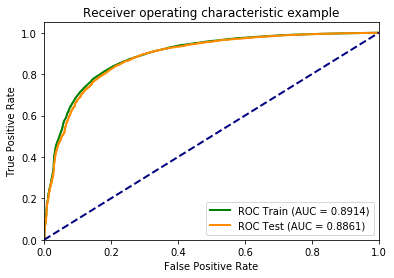

In [10]:
# Plot ROC for visual understanding of performance
# AUC ~0.88 is quite high --- and comparable to sklearn's. Great!

y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Gradient Boosting
Default parameters give train/test AUC of 0.9055/0.9045. Comparable to sklearn results, and acceptable in production setting.

In [11]:
# Explicitly displaying default parameters
ml = GBTClassifier(
    labelCol = 'label', featuresCol = 'features',
    maxDepth = 5, stepSize = 0.1,
    maxIter = 20
)

model = ml.fit(train)

In [12]:
#### Predict and evaluate performance
#### First, by printing predictions for both training and test sets

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability", "prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.92536380882826...|       0.0|    0|(23,[0,1,2,3,4,14...|
|[0.08828725570621...|       1.0|    1|(23,[4,9,15,16,22...|
|[0.07984879858429...|       1.0|    1|(23,[4,15,22],[60...|
|[0.47299668918918...|       1.0|    1|(23,[3,4,9,14,15,...|
|[0.78722029425982...|       0.0|    0|(23,[1,2,3,4,11,1...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.84605142090569...|       0.0|    0|[0.0,51.0,62.0,67...|
|[0.24406615390200...|       1.0|    1|(23,[3,4,15,21,22...|
|[0.94327009861156...|       0.0|    0|[26.0,40.0,40.0,8...|
|[0.79844950446525...|       0.0|    1|(23,[2,3,4,12,13,...|

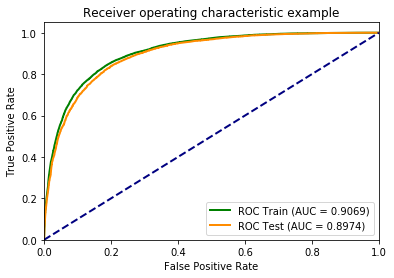

In [13]:
# Plot ROC for visual understanding of performance
# AUC ~0.89 is quite high --- and comparable to sklearn's. Great!

y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

## Cross-validation to ensure robust performance
There isn't much to tune for logistic regression, but we can try to improve the performance of gradient boosting. 

In [15]:
# Classifer to be tuned
gbt = GBTClassifier()

# Parameter grid to be searched over
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [4,5,6]) \
    .addGrid(gbt.maxIter, [20,30,40,60]) \
    .addGrid(gbt.stepSize, [0.1/3.0, 0.005, 0.1/1.5, 0.1])\
    .build()

# Define details of cross-validation; e.g. how many folds?
crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

# Run cross-validation, and choose the best set of parameters.
cvModel = crossval.fit(train)

In [ ]:
# Fit tuned model on training and test sets
cv_train = cvModel.transform(train)
cv_test = cvModel.transform(test)

# Extract output of tuned model, to be plotted as ROC
res_train = cv_train.select("probability", "label").toPandas()
res_test = cv_test.select("probability", "label").toPandas()

In [ ]:
# Plot ROC for CV-tuned model
# Result: negligible improvement for the time spent ...

y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)